# A vanilla VAE implementation for MNIST

In [1]:
import os
import sys
import time
import random
import tempfile

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.distributions import MultivariateNormal

In [2]:
%matplotlib inline
plt.ioff()

In [3]:
latent_dim = 10
dim = 784

dev = torch.device('cpu')

## Load MNIST:

In [4]:
def min_max_normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    return tensor


def tensor_round(tensor):
    return torch.round(tensor)

In [5]:
mnist_dataset = datasets.MNIST(tempfile.gettempdir(), train=True, download=True,
                       transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Lambda(lambda tensor:min_max_normalization(tensor, 0, 1)),
                            transforms.Lambda(lambda tensor:tensor_round(tensor))
                        ]))

# Take only 6's

idx = mnist_dataset.targets==6
mnist_dataset.targets = mnist_dataset.targets[idx]
mnist_dataset.data = mnist_dataset.data[idx]

## Define functions:

In [6]:
def make_encoder(dim, latent_dim):
    encoder = nn.Sequential(
        nn.Linear(dim, 500),
        nn.Tanh(),
        nn.Linear(500, 2*latent_dim),
    )
    
    return encoder

In [7]:
def make_decoder(dim, latent_dim):
    decoder = nn.Sequential(
        nn.Linear(latent_dim, 500),
        nn.Tanh(),
        nn.Linear(500, dim),
        nn.Sigmoid(),
    )
    
    return decoder

In [8]:
def compute_KL_divergence(mu, log_var):
    KL = -torch.mean(0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1))
    
    return KL

In [9]:
def compute_reconstruction_error(x, x_p):
    return -torch.mean(x*torch.log(x_p))

In [10]:
fixed_z = np.random.randn(16, latent_dim)
fixed_z = torch.Tensor(fixed_z, device=dev)
def sample_digits(model):
    imas = model(fixed_z).detach().numpy()
    imas = imas.reshape([16, 28, 28])
    return imas

In [11]:
def create_animation_digits(intermediate_results):
    
    fig, ax_arr = plt.subplots(4, 4, figsize=(15, 15))
    
    imas = intermediate_results[0]
    plots = 16*[0]
    
    for i in range(16):
        plots[i] = ax_arr[i//4, i%4].imshow(imas[i], cmap='gray', vmin=0.0, vmax=1.0)
        ax_arr[i//4, i%4].axis('off')
    
    
    def update_scat(i):
        imas = intermediate_results[i]
        for i in range(16):
            plots[i].set_data(imas[i])

    ani = animation.FuncAnimation(fig, update_scat, frames=len(intermediate_results), interval=30)
    plt.close(fig)
    
    return ani

## Train VAE:

In [12]:
batch_size = 50
epochs = 200

In [13]:
base_distr = MultivariateNormal(torch.zeros(latent_dim), torch.eye(latent_dim))

In [14]:
encoder, decoder = make_encoder(dim, latent_dim), make_decoder(dim, latent_dim)

In [15]:
train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [16]:
optimizer = torch.optim.Adam([{'params': encoder.parameters()},
                              {'params': decoder.parameters()}
                             ], lr=1e-4)

In [17]:
loss = []
KL = []


intermediate_results = []

# Train loop
t0 = time.time()
for e in range(epochs):

    cum_loss = 0
    cum_KL = 0
    count = 0
    
    for images, _ in train_loader:
        images = images.view(images.shape[0], -1)

        images = images.to(dev, non_blocking=True)

        optimizer.zero_grad()

        infer = encoder(images)
        
        mu, log_var = infer[:, :latent_dim], infer[:, latent_dim:]
        
        eps = base_distr.sample((images.shape[0],))
        
        z = mu + torch.sqrt(torch.exp(log_var)) * eps
        
        x_p = decoder(z)
        
        _NLL = compute_reconstruction_error(images, x_p)
        _KL = compute_KL_divergence(mu, log_var)
        
        _loss = _NLL + _KL


        cum_loss += _loss.item()
        cum_KL += _KL.item()
        count += 1

        _loss.backward()
        optimizer.step()

    loss.append(cum_loss/count)
    KL.append(cum_KL/count)
    intermediate_results.append(sample_digits(decoder))
        
    if e%5 == 4:
        print('epoch: {}, at time: {:.2f}, loss: {:.3e}, KL: {:.3e}'.format(e, time.time()-t0, loss[-1], KL[-1]))

epoch: 4, at time: 10.74, loss: 1.162e-02, KL: 6.704e-04
epoch: 9, at time: 19.99, loss: 2.594e-03, KL: 1.020e-04
epoch: 14, at time: 29.04, loss: 1.043e-03, KL: 5.940e-05
epoch: 19, at time: 37.87, loss: 5.455e-04, KL: 5.497e-05
epoch: 24, at time: 46.73, loss: 3.353e-04, KL: 5.980e-05
epoch: 29, at time: 55.59, loss: 2.559e-04, KL: 8.969e-05
epoch: 34, at time: 64.41, loss: 1.575e-04, KL: 5.180e-05
epoch: 39, at time: 73.24, loss: 1.353e-04, KL: 6.563e-05
epoch: 44, at time: 82.05, loss: 1.078e-04, KL: 6.115e-05
epoch: 49, at time: 90.84, loss: 8.524e-05, KL: 5.339e-05
epoch: 54, at time: 99.61, loss: 6.954e-05, KL: 4.776e-05
epoch: 59, at time: 108.40, loss: 8.635e-05, KL: 7.109e-05
epoch: 64, at time: 117.20, loss: 5.148e-05, KL: 4.070e-05
epoch: 69, at time: 126.91, loss: 6.523e-05, KL: 5.761e-05
epoch: 74, at time: 135.80, loss: 6.278e-05, KL: 5.742e-05
epoch: 79, at time: 144.67, loss: 4.094e-05, KL: 3.704e-05
epoch: 84, at time: 153.52, loss: 5.697e-05, KL: 5.422e-05
epoch: 89,

In [18]:
ani = create_animation_digits(intermediate_results)

In [19]:
HTML(ani.to_html5_video())

In [20]:
ima = x_p.detach().numpy()[0]

In [21]:
orig = images.detach().numpy()[0]

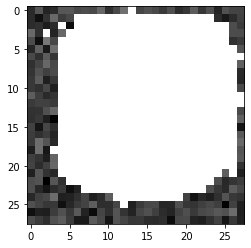

In [22]:
plt.figure()
plt.imshow(ima.reshape(28, 28), cmap='gray')
plt.show()

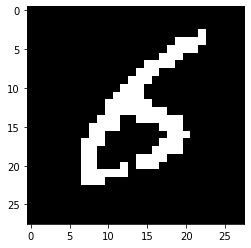

In [23]:
plt.figure()
plt.imshow(orig.reshape(28, 28), cmap='gray')
plt.show()